# 2.6 使用滑动窗口进行数据采样

在前面的章节中，我们将 token IDs 转换为连续的向量表示，也就是所谓的 token 编码，作为 LLM 的输入。然而，LLM 的一个缺点是自注意力机制（将在第 3 章详细介绍），不包含序列中的 token 位置或顺序信息。

先前介绍的 embedding 层的生成方式中，相同的 token ID 总是被映射成相同的向量表示，不会在乎 token ID 在输入序列中的位置，如图 2.17 所示。

**图 2.17 编码层将 token ID 转换为相同的向量表示，不管其在输入序列中的位置如何。例如，token ID 5 ，无论是在 token ID 输入向量的第一还是第三个位置，都将产生相同的编码向量。**

![](../img/fig-2-17.jpg)


在原则上，具有确定性的、与位置无关的编码对于可重现性是有益的。然而，由于LLM的自注意力机制本身也不关注位置，因此将额外的位置信息注入到LLM中是有帮助的。

为了实现这一点，有两种常用的位置编码方式：相对位置编码和绝对位置编码。

绝对位置编码与序列中的特定位置相关联。对于输入序列中的每个位置，都会添加一个唯一的位置编码到 token 中，来表示其确切位置。例如，第一个 token 将具有特定的位置编码，第二个 token 将具有另一个不同的位置编码，依此类推，如图2.18所示。

**图2.18 位置编码被添加到 token 中，以创建 LLM 的输入。位置向量具有与原始 token 相同的维度。出于简化考虑，token 编码显示为值为1。**

![](../img/fig-2-18.jpg)

相对位置编码不是专注于 token 的绝对位置，而是侧重于 token 之间的相对位置或距离。这意味着模型学习的是 “彼此之间有多远” 而不是 “在哪个确切位置”的关系。这样做的好处是，即使模型在训练过程中没有看到这样的长度，它也可以更好地推广到不同长度的序列。

两种类型的位置编码旨在增强 LLM 理解 token 顺序和关系的能力，确保更准确和更具上下文意识的预测。它们的选择通常取决于具体的应用程序和正在处理的数据的性质。

OpenAI 的 GPT 模型使用绝对位置编码，在训练过程中进行了优化，而不是像原始 Transformer 模型中的位置编码那样固定或预定义。这个优化过程是模型训练本身的一部分，我们将在本书的后面部分实现。现在，让我们创建初始的位置编码，为即将到来的章节创建 LLM 输入。

在本章中，我们之前专注于非常小的编码大小，以说明为目的。现在，我们考虑更现实和有用的编码大小，并将输入 token 编码为 256 维向量表示。这比原始的GPT-3 模型使用的要小（在 GPT-3 中，编码大小为 12,288 维），但对于实验来说仍然是合理的。此外，我们假设 token ID 是由我们之前实现的 BPE 标记器创建的，其词汇量大小为 50,257：
> output_dim = 256

> vocab_size = 50257

> token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

使用上面的 token_embedding_layer ，如果我们从 dataloader 中采样数据，我们将每个批次中的每个 token 编码成一个256维的向量中。如果我们的批次大小为8，每个批次有四个 token ，则结果将是一个8 x 4 x 256的张量。

首先，让我们实例化第2.6节 “使用滑动窗口进行数据采样” 的 dataloader：
>max_length = 4

>dataloader = create_dataloader_v1(
>    raw_text, batch_size=8, max_length=max_length, stride=max_len)

>data_iter = iter(dataloader)

>inputs, targets = next(data_iter)

>print("Token IDs:\n", inputs)

>print("\nInputs shape:\n", inputs.shape)

前面的代码打印如下输出:
>Token IDs:

>tensor([[   40,   367,  2885,  1464],\
        [ 1807,  3619,   402,   271],\
        [10899,  2138,   257,  7026],\
        [15632,   438,  2016,   257],\
        [  922,  5891,  1576,   438],\
        [  568,   340,   373,   645],\
        [ 1049,  5975,   284,   502],\
        [  284,  3285,   326,    11]])
        
>Inputs shape:
 >torch.Size([8, 4])

正如我们所看到的，token ID 张量是 8x4 维的，这意味着数据批次由 8 个文本样本组成，每个样本有 4 个 token。

现在让我们使用 token_embedding_layer 将这些 token ID 嵌入为 256 维的向量：
> token_embeddings = token_embedding_layer(inputs)
> 
> print(token_embeddings.shape)

前面的代码打印如下输出:

>torch.Size([8, 4, 256])

根据 8x4x256 维的张量输出，我们可以看出每个 token ID 现在被嵌入为一个 256 维的向量。
对于 GPT 模型的绝对嵌入方法，我们只需要创建另一个具有与 token_embedding_layer 相同维度的嵌入层：

>context_length = max_length

>pos_embedding_layer = torch.nn.Embedding(context_lengthe, output_dim)

>pos_embeddings = pos_embedding_layer(torch.arange(context_length))

>print(pos_embeddings.shape)

如前面的代码示例所示，pos_embeddings 的输入通常是一个占位符向量 torch.arange(context_length)，其中包含一系列数字 0、1、...，一直到最大输入长度减 1。context_length 是一个变量，表示 LLM 支持的输入大小。在这里，我们选择它与输入文本的最大长度类似。在实践中，输入文本可以比支持的上下文长度长。这种情况下，我们必须截断文本。

print 语句的输出如下：

>torch.Size([4, 256])


正如我们所见，位置嵌入张量由四个 256 维向量组成。我们现在可以直接将它们添加到标记嵌入中，PyTorch 将在每个 8 批次中的每个 4x256 维标记嵌入张量中添加 4x256 维的 pos_embeddings 张量：
>input_embeddings = token_embeddings + pos_embeddings

>print(input_embeddings.shape)

print 输出如下：

>torch.Size([8, 4, 256])

我们创建的 input_embeddings，如图 2.19 所总结的，是嵌入的输入示例，现在可以由我们将在第 3 章开始实现的主要 LLM 模块进行处理。

![](../img/fig-2-19.jpg)
**图 2.19 作为输入处理流程的一部分，输入文本首先被分解为单个 token 。然后使用词汇表将这些标记转换为 token ID。将 token ID 转换为编码向量，然后添加相似大小的位置编码，生成用作主要 LLM 层的输入编码。**



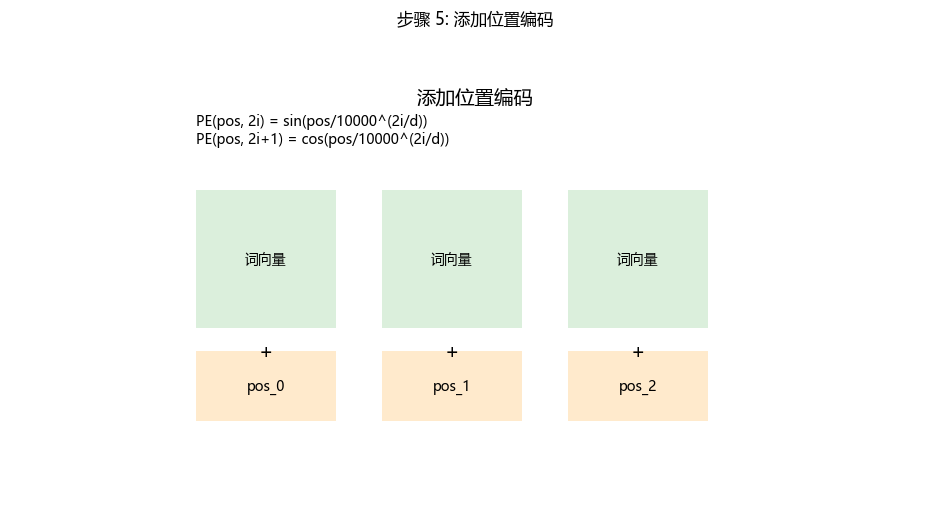

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle
from IPython.display import clear_output, display
import time

def create_tokenization_visualization():
    # 设置中文字体
    plt.rcParams['font.family'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 定义颜色方案
    colors = {
        'background': '#ffffff',
        'text': '#333333',
        'token': '#2196f3',
        'embedding': '#4caf50',
        'position': '#ff9800',
        'final': '#9c27b0'
    }
    
    # 示例数据
    text = "I love ML"
    tokens = ['I', 'love', 'ML']
    token_ids = [24, 456, 789]
    
    # 场景列表
    scenes = [
        # 场景1: 原始文本
        lambda: (lambda: plt.subplots(figsize=(12, 6)), 
                lambda ax: [
                    ax.text(0.5, 0.7, f'输入文本: "{text}"', ha='center', va='center', fontsize=14),
                    ax.set_title('步骤 1: 原始文本输入', pad=20)
                ]),
        
        # 场景2: 分词过程
        lambda: (lambda: plt.subplots(figsize=(12, 6)),
                lambda ax: [
                    ax.text(0.5, 0.9, '分词过程', ha='center', va='center', fontsize=14),
                    [ax.add_patch(FancyBboxPatch(
                        (0.2 + i*0.2, 0.5),
                        0.15, 0.15,
                        boxstyle="round,pad=0.1",
                        facecolor=colors['token'],
                        alpha=0.3
                    )) for i, token in enumerate(tokens)],
                    [ax.text(0.275 + i*0.2, 0.575, token, ha='center', va='center')
                     for i, token in enumerate(tokens)],
                    ax.set_title('步骤 2: 文本分词', pad=20)
                ]),
        
        # 场景3: Token ID转换
        lambda: (lambda: plt.subplots(figsize=(12, 6)),
                lambda ax: [
                    ax.text(0.5, 0.9, 'Token ID转换', ha='center', va='center', fontsize=14),
                    [(ax.add_patch(FancyBboxPatch(
                        (0.2 + i*0.2, 0.6),
                        0.15, 0.15,
                        boxstyle="round,pad=0.1",
                        facecolor=colors['token'],
                        alpha=0.3
                    )),
                      ax.text(0.275 + i*0.2, 0.675, token, ha='center', va='center'),
                      ax.add_patch(FancyBboxPatch(
                          (0.2 + i*0.2, 0.4),
                          0.15, 0.15,
                          boxstyle="round,pad=0.1",
                          facecolor=colors['embedding'],
                          alpha=0.3
                      )),
                      ax.text(0.275 + i*0.2, 0.475, f'ID: {token_id}', ha='center', va='center'),
                      ax.arrow(0.275 + i*0.2, 0.6, 0, -0.05, head_width=0.01, head_length=0.02,
                             fc='black', ec='black'))
                     for i, (token, token_id) in enumerate(zip(tokens, token_ids))],
                    ax.set_title('步骤 3: 转换为Token ID', pad=20)
                ]),
        
        # 场景4: 词嵌入
        lambda: (lambda: plt.subplots(figsize=(12, 6)),
                lambda ax: [
                    ax.text(0.5, 0.9, '词嵌入转换', ha='center', va='center', fontsize=14),
                    [(ax.add_patch(FancyBboxPatch(
                        (0.2 + i*0.2, 0.7),
                        0.15, 0.15,
                        boxstyle="round,pad=0.1",
                        facecolor=colors['embedding'],
                        alpha=0.3
                    )),
                      ax.text(0.275 + i*0.2, 0.775, f'ID: {token_ids[i]}', ha='center', va='center'),
                      ax.add_patch(Rectangle(
                          (0.2 + i*0.2, 0.3),
                          0.15, 0.3,
                          facecolor=colors['embedding'],
                          alpha=0.2
                      )),
                      ax.text(0.275 + i*0.2, 0.45, '词向量\n[...]\n[...]', ha='center', va='center'),
                      ax.arrow(0.275 + i*0.2, 0.7, 0, -0.1, head_width=0.01, head_length=0.02,
                             fc='black', ec='black'))
                     for i in range(3)],
                    ax.set_title('步骤 4: 词嵌入转换', pad=20)
                ]),
        
        # 场景5: 位置编码
        lambda: (lambda: plt.subplots(figsize=(12, 6)),
                lambda ax: [
                    ax.text(0.5, 0.9, '添加位置编码', ha='center', va='center', fontsize=14),
                    ax.text(0.2, 0.8, 
                           "PE(pos, 2i) = sin(pos/10000^(2i/d))\n" + 
                           "PE(pos, 2i+1) = cos(pos/10000^(2i/d))",
                           fontsize=10),
                    [(ax.add_patch(Rectangle(
                        (0.2 + i*0.2, 0.4),
                        0.15, 0.3,
                        facecolor=colors['embedding'],
                        alpha=0.2
                    )),
                      ax.text(0.275 + i*0.2, 0.55, '词向量', ha='center', va='center'),
                      ax.add_patch(Rectangle(
                          (0.2 + i*0.2, 0.2),
                          0.15, 0.15,
                          facecolor=colors['position'],
                          alpha=0.2
                      )),
                      ax.text(0.275 + i*0.2, 0.275, f'pos_{i}', ha='center', va='center'),
                      ax.text(0.275 + i*0.2, 0.35, '+', ha='center', va='center', fontsize=14))
                     for i in range(3)],
                    ax.set_title('步骤 5: 添加位置编码', pad=20)
                ])
    ]
    
    # 显示每个场景
    for scene in scenes:
        fig, ax = scene()[0]()
        ax.axis('off')
        scene()[1](ax)
        display(plt.gcf())
        time.sleep(5)  # 每个场景显示5秒
        clear_output(wait=True)
        plt.close()
    
    # 显示最后一个场景（不清除）
    fig, ax = scenes[-1]()[0]()
    ax.axis('off')
    scenes[-1]()[1](ax)
    display(plt.gcf())

# 运行可视化
create_tokenization_visualization()

比较有位置和没有位置编码的区别

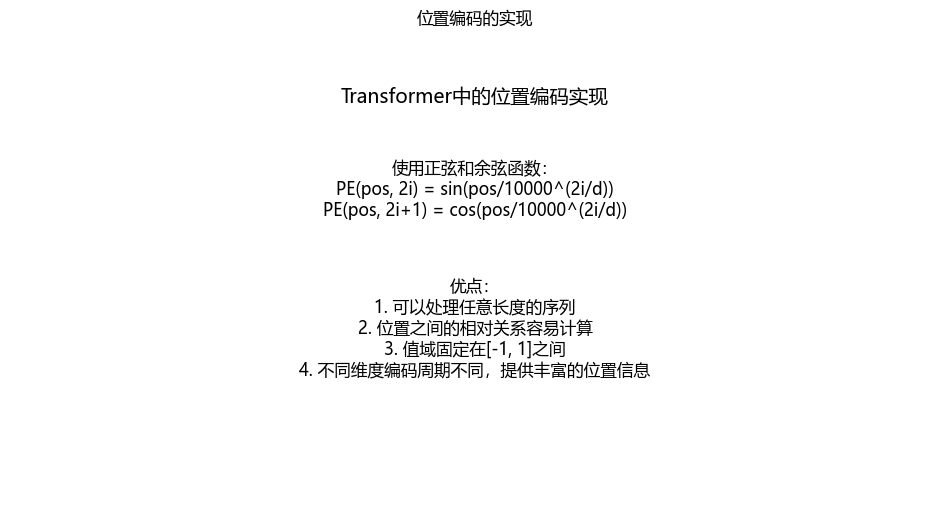

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle
from IPython.display import clear_output, display
import time

def show_position_encoding_importance():
    # 设置中文字体
    plt.rcParams['font.family'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 定义颜色方案
    colors = {
        'text': '#333333',
        'highlight1': '#2196f3',
        'highlight2': '#f44336',
        'normal': '#4caf50'
    }
    
    scenes = [
        # 场景1: 问题引入
        lambda: (lambda: plt.subplots(figsize=(12, 6)),
                lambda ax: [
                    ax.text(0.5, 0.8, "为什么需要位置编码？", ha='center', va='center', fontsize=16, color=colors['text']),
                    ax.text(0.5, 0.5, "考虑这两个句子：\n\n"
                           "'I love you' vs 'you love I'\n\n"
                           "词语相同，但因位置不同，含义完全不同！",
                           ha='center', va='center', fontsize=14, color=colors['text']),
                    ax.set_title('位置编码的重要性', pad=20)
                ]),
        
        # 场景2: 没有位置信息的问题
        lambda: (lambda: plt.subplots(figsize=(12, 6)),
                lambda ax: [
                    ax.text(0.5, 0.9, "没有位置编码时的问题", ha='center', va='center', fontsize=14),
                    # 第一个句子
                    [ax.add_patch(FancyBboxPatch(
                        (0.2 + i*0.15, 0.6),
                        0.12, 0.12,
                        boxstyle="round,pad=0.1",
                        facecolor='white',
                        edgecolor=colors['highlight1']
                    )) for i in range(3)],
                    [ax.text(0.26 + i*0.15, 0.66, word, ha='center', va='center')
                     for i, word in enumerate(['I', 'love', 'you'])],
                    # 第二个句子
                    [ax.add_patch(FancyBboxPatch(
                        (0.2 + i*0.15, 0.3),
                        0.12, 0.12,
                        boxstyle="round,pad=0.1",
                        facecolor='white',
                        edgecolor=colors['highlight2']
                    )) for i in range(3)],
                    [ax.text(0.26 + i*0.15, 0.36, word, ha='center', va='center')
                     for i, word in enumerate(['you', 'love', 'I'])],
                    ax.text(0.6, 0.45, "→ 模型看到的词嵌入完全相同！\n无法区分词序", 
                           ha='left', va='center', fontsize=12, color=colors['text']),
                    ax.set_title('没有位置信息的问题', pad=20)
                ]),
        
        # 场景3: 位置编码的作用
        lambda: (lambda: plt.subplots(figsize=(12, 6)),
                lambda ax: [
                    ax.text(0.5, 0.9, "添加位置编码后", ha='center', va='center', fontsize=14),
                    # 第一个句子
                    [(ax.add_patch(FancyBboxPatch(
                        (0.2 + i*0.15, 0.6),
                        0.12, 0.12,
                        boxstyle="round,pad=0.1",
                        facecolor='white',
                        edgecolor=colors['highlight1']
                    )),
                      ax.text(0.26 + i*0.15, 0.66, f"{word}\n+\npos_{i}", ha='center', va='center'))
                     for i, word in enumerate(['I', 'love', 'you'])],
                    # 第二个句子
                    [(ax.add_patch(FancyBboxPatch(
                        (0.2 + i*0.15, 0.3),
                        0.12, 0.12,
                        boxstyle="round,pad=0.1",
                        facecolor='white',
                        edgecolor=colors['highlight2']
                    )),
                      ax.text(0.26 + i*0.15, 0.36, f"{word}\n+\npos_{i}", ha='center', va='center'))
                     for i, word in enumerate(['you', 'love', 'I'])],
                    ax.text(0.6, 0.45, "→ 每个位置都有唯一的编码\n模型可以区分词序！", 
                           ha='left', va='center', fontsize=12, color=colors['text']),
                    ax.set_title('位置编码的作用', pad=20)
                ]),
        
        # 场景4: 位置编码的优势
        lambda: (lambda: plt.subplots(figsize=(12, 6)),
                lambda ax: [
                    ax.text(0.5, 0.8, "位置编码的优势", ha='center', va='center', fontsize=16),
                    ax.text(0.5, 0.6, 
                           "1. 保持词序信息\n" +
                           "2. 使模型理解语法结构\n" +
                           "3. 区分相同词在不同位置的含义\n" +
                           "4. 帮助模型理解长距离依赖\n" +
                           "5. 位置编码可以泛化到不同长度的序列",
                           ha='center', va='center', fontsize=14),
                    ax.set_title('位置编码的重要性', pad=20)
                ]),
        
        # 场景5: 具体实现
        lambda: (lambda: plt.subplots(figsize=(12, 6)),
                lambda ax: [
                    ax.text(0.5, 0.9, "Transformer中的位置编码实现", ha='center', va='center', fontsize=14),
                    ax.text(0.5, 0.7, 
                           "使用正弦和余弦函数：\n" +
                           "PE(pos, 2i) = sin(pos/10000^(2i/d))\n" +
                           "PE(pos, 2i+1) = cos(pos/10000^(2i/d))",
                           ha='center', va='center', fontsize=12),
                    ax.text(0.5, 0.4,
                           "优点：\n" +
                           "1. 可以处理任意长度的序列\n" +
                           "2. 位置之间的相对关系容易计算\n" +
                           "3. 值域固定在[-1, 1]之间\n" +
                           "4. 不同维度编码周期不同，提供丰富的位置信息",
                           ha='center', va='center', fontsize=12),
                    ax.set_title('位置编码的实现', pad=20)
                ])
    ]
    
    # 显示每个场景
    for scene in scenes:
        fig, ax = scene()[0]()
        ax.axis('off')
        scene()[1](ax)
        display(plt.gcf())
        time.sleep(6)  # 每个场景显示6秒
        clear_output(wait=True)
        plt.close()
    
    # 显示最后一个场景（不清除）
    fig, ax = scenes[-1]()[0]()
    ax.axis('off')
    scenes[-1]()[1](ax)
    display(plt.gcf())

# 运行可视化
show_position_encoding_importance()